# Purpose:
     Example usage of CompanySim package to build a graph on a company corpus and then use the Jaccard Similarity   and a Dot Product Score to determine similarity between pairs of companies

1) Import a curated dataset of ~100,000 companies, each with a pitch book description, and some with a crunch base provided description. Both descriptions text has been combined into one text in the 'comb_desc' column

In [6]:
from companysim import CompanyCorpus, CompanyGraph
import pandas as pd
import numpy as np

### 100,000 companies with combined cb and pb descriptions as well as the companies from the training set
company_list = pd.read_csv('../data/100k_cb_and_pb_desc.csv',  encoding = "ISO-8859-1", \
                           usecols=['domain', 'tx_industry', 'cb_category', 'tx_category', 'pb_desc',
                                    'cb_desc', 'pb_category', 'comb_desc'], dtype={2: str, 4: str})

print(company_list.shape)
company_list.head()

ImportError: cannot import name 'CompanyCorpus'

2) Utilize the CompanySim package to create a CompanyCorpus and a CompanyGraph
 - CompanyCorpus takes a pandas DataFrame as input (see company_list structure above) and takes care of computing the idf vector as well as filtering descriptions by top IDF value
 - CompanyGraph takes the created CompanyCorpus object as input and builds the LSH forest and the Graph from the LSH forest
 
 Note: This takes ~25-40 minutes to run depending on NUMBER_SIMILAR_COMPANIES (keep less than 200) and computer run on

 Note 2: The percent complete has a little bug and stops at 99% but it actually completed, I just haven't fixed it yet

In [5]:
# Setup CompanyCorpus Instance
from timeit import default_timer as timer

start = timer()

# Tuning parameters
NUMBER_OF_WORDS = 50
NUMBER_SIMILAR_COMPANIES = 100

# Inputs:
DESCRIPTION_COLUMN = 'comb_desc'

NAME_COLUMN = 'domain'

# Create an instance of the CompanyCorpus class using the company list
cc = cs.CompanyCorpus(company_list)

# Build the idf_vector
cc.build_idf(description_column_name=DESCRIPTION_COLUMN)
print("IDF Completed!")
# Filter descriptions by cutting out the number of words specified in NUMBER_OF_WORDS
cc.filter_desc_by_idf(description_column_name=DESCRIPTION_COLUMN,
                      number_words_to_cut=NUMBER_OF_WORDS)

# Create a CompanyGraph
cg = cs.CompanyGraph(cc)
cg.build_lsh_forest(company_name_column_name=NAME_COLUMN)
cg.build_graph(sensitivity=NUMBER_SIMILAR_COMPANIES)

end = timer()
print("Time: {0:0.2f} minutes".format((end - start)/60)) 

# Show info about the completed graph
cg.graph


NameError: name 'tfidf' is not defined

3) Import the training data set to now build the KNN classifier

In [7]:
# Import Training data:
#     Set of company pairs with pitch book descriptions for use in training a classifier
training_pairs_df = pd.read_csv('../data/rated_pairs_1_3_only_filtered_desc.csv') # rated_pairs_1_3_only_cb_desc
print("Number of companies in training set: {}".format(training_pairs_df.shape[0]))

935


4) Set up the training data set by creating a new dataframe of the company pairs with their corresponding dot product score, jaccard similarity and known rating

In [8]:
### Set up the training and test data

dot_scores = []
jaccard_sims = []

idf_set = set(cg.company_corpus.idf_vector.index)
idf_map_dict = dict(zip(cg.company_corpus.idf_vector.index, cg.company_corpus.idf_vector.values))
company_words_list = list(cg.company_corpus.corpus.loc[:, 'rare_words'])

for domain1, domain2 in zip(training_pairs_df['domain1'].values, training_pairs_df['domain2'].values):
    dot_score = cg.get_dot_product_score(domain1, domain2)
    dot_scores.append(dot_score)

    jaccard_sim_score = cg.get_jaccard_similarity(domain1, domain2)
    jaccard_sims.append(jaccard_sim_score)
    
    
training_data_df = training_pairs_df.loc[:,('domain1', 'domain2', 'rating')]
training_data_df['dot_product'] = dot_scores
training_data_df['jaccard'] = jaccard_sims


# Change all '3' ratings to '0' rating 
training_data_df['rating'] = training_data_df['rating'].replace(3, 0)

training_data_df.head()

,domain1,domain2,rating,dot_product,jaccard
0,2trg.com,2u.com,0,0.000000,0.000000
1,teamtreehouse.com,onkea.com,0,0.058293,0.068986
2,andara.bi,domo.com,1,0.000000,0.000000
3,bugcrowd.com,synack.com,1,0.001760,0.068500
4,i2istudy.com,livemocha.com,1,0.000000,0.104900


5) Setup the data further by splitting the features and known ratings into training and test data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Get both the score and jaccard similarity into one feature matrix
features_all = np.array((training_data_df['dot_product'], training_data_df['jaccard'])).T

# Get the known ratings for the model
known_ratings = training_data_df['rating'].values

# Shuffle the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_all, known_ratings, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)

(701, 2)
(234, 2)


6) Perform cross validation of the KNN model to get the best number of neighbors to use

The optimal number of neighbors is 21


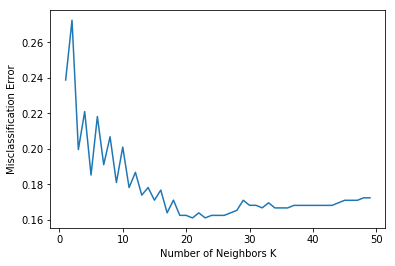

In [21]:
import matplotlib.pyplot as plt

# Perform Cross Validation of KNN classifier

neighbors = list(range(1,50))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

7) Run the KNN model and show the predicted outcomes to get some visual as to if they are all 1's, all 0's or a good mix

In [22]:
# Train model using optimal neighbors value found previously

clf = KNeighborsClassifier(n_neighbors=optimal_k)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
predicted = clf.predict(X_test)
predicted

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1])

8) Now this section calculates all the important evaluation metrics and prints them out

In [24]:
from sklearn import metrics
# Print out some important statistics

accuracy = predicted - y_test

correctness = float(len(accuracy[accuracy == 0]))/len(accuracy)
underestimation = float(len(accuracy[accuracy > 0]))/len(accuracy)
overestimation = float(len(accuracy[accuracy < 0]))/len(accuracy)
print('Percent correct = {0:0.3f}%'.format(correctness*100))
print('Percent predicted 1, should be 0 (Less Bad) = {0:0.3f}%'.format(underestimation*100))
print('Percent predicted 0, should be 1 (Very Bad) = {0:0.3f}%'.format(overestimation*100))

root_mean_squared_error = np.sqrt(float(sum(np.square(accuracy)))/len(accuracy))
print('RMSE = {0:0.5f}'.format(root_mean_squared_error))

mean_absolute_value_error = float(sum(abs(accuracy)))/len(accuracy)
print('Mean Error = {0:0.5f}'.format(mean_absolute_value_error))


print(metrics.classification_report(y_test, predicted, labels=[0,1]))

Percent correct = 85.043%
Percent predicted 1, should be 0 (Less Bad) = 12.393%
Percent predicted 0, should be 1 (Very Bad) = 2.564%
RMSE = 0.38675
Mean Error = 0.14957
             precision    recall  f1-score   support

          0       0.95      0.80      0.87       144
          1       0.74      0.93      0.83        90

avg / total       0.87      0.85      0.85       234



9) This code plots the confusion matrix

Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.07  0.93]]


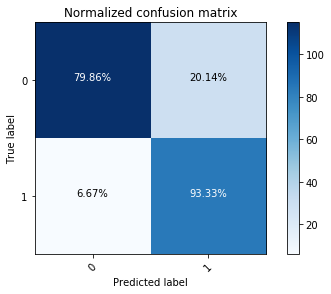

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

class_names = np.array([0,1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{0:0.2f}%".format(cm[i, j]*100),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

10) This code plots the training data in a dot product vs. Jaccard similarity graph to visualize how the KNN might be making a distinction 

Number of 1's: 379
Number of 0's: 556


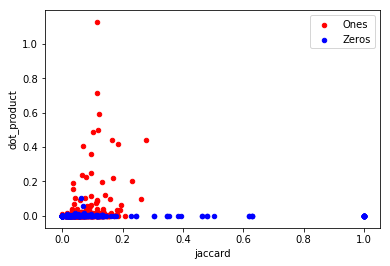

In [27]:
ones_df = training_data_df.loc[training_data_df['rating'] == 1]
zeros_df = training_data_df.loc[training_data_df['rating'] == 0]

print("Number of 1's: {}".format(ones_df.shape[0]))
print("Number of 0's: {}".format(zeros_df.shape[0]))

ax = ones_df.plot.scatter(x='jaccard', y='dot_product', color='r', label='Ones')
zeros_df.plot.scatter(x='jaccard', y='dot_product', color='b', label='Zeros', ax=ax)
plt.show()

11) This code zooms in on the above plot to see the values better closer to zero

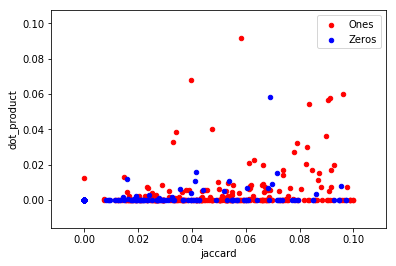

In [28]:
ones_df = ones_df.loc[ones_df['jaccard'] <= 0.1]
zeros_df = zeros_df.loc[zeros_df['jaccard'] <= 0.1]
ones_df = ones_df.loc[ones_df['dot_product'] <= 0.1]
zeros_df = zeros_df.loc[zeros_df['dot_product'] <= 0.1]

ax = ones_df.plot.scatter(x='jaccard', y='dot_product', color='r', label='Ones')
zeros_df.plot.scatter(x='jaccard', y='dot_product', color='b', label='Zeros', ax=ax)
plt.show()